**Dataset used:** https://ucdp.uu.se/country/771

**Goal of ML:** To predict the likelihood of cross-border conflict events involving Bangladesh using historical event-level data, in a theoretical early-warning scenario intended to inform preparedness and alertness planning.

# Initial Setup (needed for Google Colab)

In [1]:
%pip install ydata-profiling gradio

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import OneClassSVM
from sklearn.metrics import f1_score, recall_score
from ydata_profiling import ProfileReport
import pickle
import seaborn as sns
import gradio as gr

print("Libraries loaded successfully.")

Libraries loaded successfully.


# Task 1: Data Loading

In [3]:
csv_file = "https://raw.githubusercontent.com/MushfiqPlabon/ucdp_border_crossing_ml/refs/heads/main/gedevents-2026-01-17.csv"

df = pd.read_csv(csv_file, index_col=False)
print(f"Data loaded. Shape: {df.shape}")
df.head()

Data loaded. Shape: (693, 47)


,id,relid,year,active_year,code_status,type_of_violence,conflict_dset_id,conflict_new_id,conflict_name,dyad_dset_id,...,date_prec,date_start,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best_est,high_est,low_est
0,210432,BNG-2015-3-2087-0,2015,False,Clear,3,1218,2009,JMB - Civilians,1218,...,1,09/04/2015 00:00:00,09/04/2015 00:00:00,0,0,2,0,2,2,2
1,210433,BNG-2015-3-1076-1,2015,True,Clear,3,234,506,IS - Civilians,234,...,1,09/28/2015 00:00:00,09/28/2015 00:00:00,0,0,1,0,1,1,1
2,210436,BNG-2015-3-1076-2,2015,True,Clear,3,234,506,IS - Civilians,234,...,1,10/03/2015 00:00:00,10/03/2015 00:00:00,0,0,1,0,1,1,1
3,210459,BNG-2015-3-1076-3,2015,True,Clear,3,234,506,IS - Civilians,234,...,1,10/24/2015 00:00:00,10/24/2015 00:00:00,0,0,1,0,1,1,1
4,210470,BNG-2015-1-14718-0,2015,False,Clear,1,13674,13674,Bangladesh: Islamic State,14718,...,1,11/04/2015 00:00:00,11/04/2015 00:00:00,1,0,0,0,1,1,1


In [4]:
# Subtask: EDA
# ProfileReport(df, title="EDA", explorative=True).to_file(
#     "EDA-Report.html"
# )  # For generating downloadeable HTML
# ProfileReport(df, title="EDA", explorative=True) # To view inside colab without requiring download



*   The dataset contains event-level armed conflict records from the Uppsala Conflict Data Program (UCDP).

*   Each row represents a single conflict event with temporal, geographic, and conflict-related attributes.

*   The objective is to predict whether an event involved a cross-border incident.

# Task 2: Data Preprocessing

Total Events: 693
Identified Border Violations: 8
Training Set Size: 554
Testing Set Size: 139


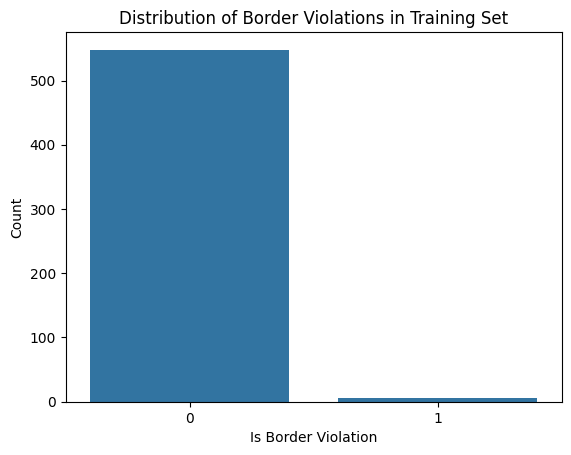

In [5]:
# Step 1: Target Definition (Feature Engineering)
# Identifying Border Violations (Class 1) vs Internal (Class 0)
def define_target(row: pd.Series) -> int:
    text = f"{str(row['side_a'])} {str(row['side_b'])} {str(row.get('source_headline', ''))}".lower()
    keywords = [
        "border",
        "bsf",
        "bgb",
        "bgp",
        "bdr",
        "rifles",
        "crossing",
        "fence",
        "pushback",
        "no man's land",
        "zero line",
    ]
    return 1 if any(k in text for k in keywords) else 0


df["is_border_violation"] = df.apply(define_target, axis=1)

# Step 2: Feature Extraction (Getting month)
df["month"] = pd.to_datetime(df["date_start"]).dt.month

# Step 3: Handling Missing Values
df = df.dropna(subset=["latitude", "longitude", "year", "type_of_violence", "month"])

# Step 4: Feature Selection
X = df[["latitude", "longitude", "year", "month", "type_of_violence"]]
y = df["is_border_violation"]

# Step 5: Stratified Split (80/20)
# Uses stratify=y to maintain the 8/693 ratio in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Total Events: {len(df)}")
print(f"Identified Border Violations: {df['is_border_violation'].sum()}")
print(f"Training Set Size: {len(X_train)}")
print(f"Testing Set Size: {len(X_test)}")

# Visualising the distribution of border violations in the training set
sns.countplot(x=y_train)
plt.title("Distribution of Border Violations in Training Set")
plt.xlabel("Is Border Violation")
plt.ylabel("Count")
plt.show()

# Task 3: Pipeline Creation

In [6]:
# Scaling numerical coordinates/years and encoding categorical violence types
preprocessor = ColumnTransformer(
    [
        ("num", StandardScaler(), ["latitude", "longitude", "year", "month"]),
        ("cat", OneHotEncoder(handle_unknown="ignore"), ["type_of_violence"]),
    ]
)

custom_weights = {
    0: 1,
    1: 100,
}  # Forcing the model to value 1 border event as much as 100 internal ones

pipeline = Pipeline(
    [
        ("pre", preprocessor),
        (
            "clf",
            RandomForestClassifier(
                n_estimators=500,  # More trees to reduce variance on the 8 samples
                class_weight=custom_weights,
                min_samples_leaf=1,  # REQUIRED: With only 8 samples, we can't require 2 per leaf
                max_depth=None,  # Letting the tree grow deep enough to capture the specific border coords
                random_state=42,
                criterion="entropy",  # Better for our heavily imbalanced dataset
            ),
        ),
    ]
)

# Visualising dataset sizes
print(f"Total Events: {len(df)}")
print(f"Identified Border Violations: {df['is_border_violation'].sum()}")
print(f"Training Set Size: {len(X_train)}")

Total Events: 693
Identified Border Violations: 8
Training Set Size: 554


# Task 4: Primary Model Selection


**Selection:** Random Forest Classifier.

**Justification:** The YData showed that conflict events are non-linearly distributed across coordinates. Random Forest is ideal for this dataset because it handles the non-linear relationship between geography and conflict types well.
It is inherently robust to the noise present in UCDP event reporting and offers 'class_weight' parameters to handle the rarity of border events.

# Task 5: Model Training

In [7]:
pipeline.fit(X_train, y_train)
print("Initial Model Training Complete.")

Initial Model Training Complete.


# Task 6: Cross-Validation

Starting Robust Cross-Validation (100 runs per model)...
--- BATTLE RESULTS ---
RandomForest (Balanced): F1=0.575 (+/- 0.147) | Border Recall=0.170
AdaBoost (Stumps): F1=0.590 (+/- 0.127) | Border Recall=0.315
OneClassSVM (Anomaly): F1=0.556 (+/- 0.056) | Border Recall=0.745
Best Model Selected: OneClassSVM (Anomaly)


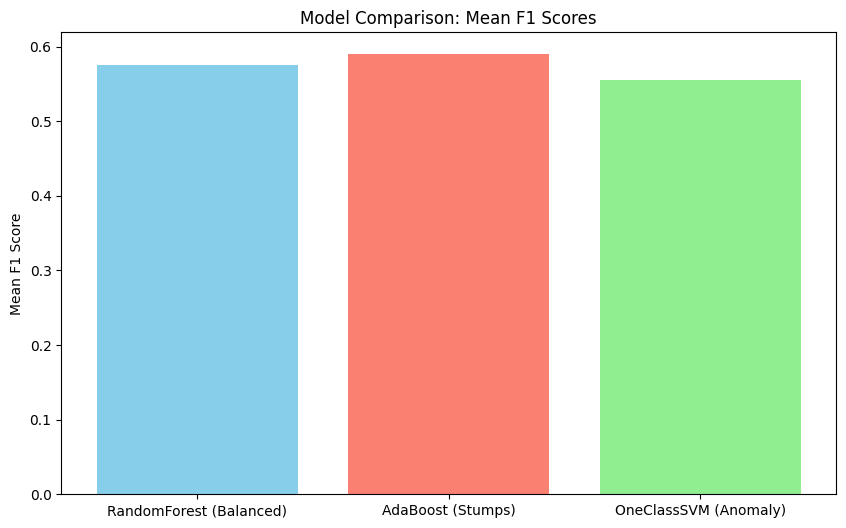

In [8]:
# --- 1. Robust Validation Setup ---
rskf = RepeatedStratifiedKFold(n_splits=4, n_repeats=25, random_state=42)


# --- 2. Optimising Manual Upsampling Function ---
def upsample_minority(
    X: pd.DataFrame, y: pd.Series, target_count: int = 500
) -> tuple[pd.DataFrame, pd.Series]:
    # Working with indices to avoid expensive dataframe copying
    minority_indices = y[y == 1].index.to_numpy()
    majority_indices = y[y == 0].index.to_numpy()

    # Randomly sampling minority indices with replacement
    upsampled_min_idx = np.random.choice(
        minority_indices, size=target_count, replace=True
    )

    # Combining majority and upsampled minority indices
    new_indices = np.concatenate([majority_indices, upsampled_min_idx])
    np.random.shuffle(new_indices)

    return X.loc[new_indices], y.loc[new_indices]


# --- 3. Model Configurations ---
models = {
    "RandomForest (Balanced)": RandomForestClassifier(
        n_estimators=1000,
        max_depth=5,
        class_weight="balanced_subsample",
        random_state=42,
    ),
    "AdaBoost (Stumps)": AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50, random_state=42
    ),
    "OneClassSVM (Anomaly)": OneClassSVM(kernel="rbf", nu=0.01),
}

# --- 4. The Comparison Loop ---
results = {name: {"f1": [], "recall": []} for name in models}
print("Starting Robust Cross-Validation (100 runs per model)...")

for i, (train_idx, val_idx) in enumerate(rskf.split(X_train, y_train)):
    # Slicing using indices (View vs Copy optimization)
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Pipeline Processing
    X_tr_proc = preprocessor.fit_transform(X_tr)
    X_val_proc = preprocessor.transform(X_val)

    # Applying Upsampling only to Training Data (To Prevent Leakage)
    X_tr_up, y_tr_up = upsample_minority(
        pd.DataFrame(X_tr_proc, index=X_tr.index), y_tr, target_count=len(y_tr)
    )

    for name, model in models.items():
        if "OneClass" in name:
            # Anomaly detection trains only on Majority Class (Internal Conflict)
            model.fit(X_tr_proc[y_tr == 0])
            preds = np.where(model.predict(X_val_proc) == -1, 1, 0)
        else:
            # Classifiers train on Upsampled Balanced Data
            model.fit(X_tr_up, y_tr_up)
            preds = model.predict(X_val_proc)

        results[name]["f1"].append(f1_score(y_val, preds, average="macro"))
        results[name]["recall"].append(recall_score(y_val, preds, pos_label=1))

# --- 5. Displaying Results ---
print("--- BATTLE RESULTS ---")
for name, metrics in results.items():
    print(
        f"{name}: F1={np.mean(metrics['f1']):.3f} (+/- {np.std(metrics['f1']):.3f}) | Border Recall={np.mean(metrics['recall']):.3f}"
    )

# --- 6. Visualize Results ---
best_model_name = max(results, key=lambda n: np.mean(results[n]["recall"]))
best_model = models[best_model_name]
print(f"Best Model Selected: {best_model_name}")

plt.figure(figsize=(10, 6))
model_names = list(results.keys())
f1_means = [np.mean(results[name]["f1"]) for name in model_names]
plt.bar(model_names, f1_means, color=["skyblue", "salmon", "lightgreen"])
plt.ylabel("Mean F1 Score")
plt.title("Model Comparison: Mean F1 Scores")
plt.show()

# Task 7: Hyperparameter Tuning


Tuning AdaBoost (Stumps)...
Parameters to test: {'n_estimators': [50, 100, 200], 'learning_rate': [0.5, 1.0, 1.5]}
Best Parameters Found: {'learning_rate': 1.5, 'n_estimators': 100}
Best Grid Score: 0.9927


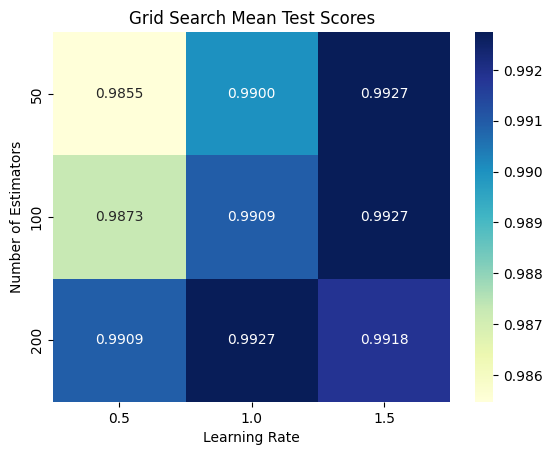

In [9]:
# Optimising the best performing model (likely AdaBoost) from the Cross-Validation step.
# Parameters tested: n_estimators, learning_rate

prob_model_name = "AdaBoost (Stumps)"
base_model = models[prob_model_name]

param_grid = {"n_estimators": [50, 100, 200], "learning_rate": [0.5, 1.0, 1.5]}

print(f"Tuning {prob_model_name}...")
print(f"Parameters to test: {param_grid}")

# Using a simplified CV for tuning speed, utilizing the preprocessor
grid = GridSearchCV(base_model, param_grid, cv=3, scoring="f1_macro", n_jobs=-1)

# Preprocessing full training set for grid search
X_train_proc = preprocessor.fit_transform(X_train)
# Upsampling once for grid search to handle imbalance during tuning
X_train_up, y_train_up = upsample_minority(
    pd.DataFrame(X_train_proc, index=X_train.index), y_train, target_count=len(y_train)
)

grid.fit(X_train_up, y_train_up)

print(f"Best Parameters Found: {grid.best_params_}")
print(f"Best Grid Score: {grid.best_score_:.4f}")

# Visualising parameter effects
results_df = pd.DataFrame(grid.cv_results_)
pivot_table = results_df.pivot_table(
    values="mean_test_score", index="param_n_estimators", columns="param_learning_rate"
)
sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title("Grid Search Mean Test Scores")
plt.xlabel("Learning Rate")
plt.ylabel("Number of Estimators")
plt.show()

# Task 8: Best Model Selection


Final Selected Probability Model: AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=1.5, n_estimators=100, random_state=42)
Final Selected Anomaly Model: OneClassSVM(nu=0.01)
Best Models Selected and Unified into Hybrid System.
              precision    recall  f1-score   support

           0     1.0000    0.9343    0.9660       137
           1     0.1818    1.0000    0.3077         2

    accuracy                         0.9353       139
   macro avg     0.5909    0.9672    0.6369       139
weighted avg     0.9882    0.9353    0.9566       139



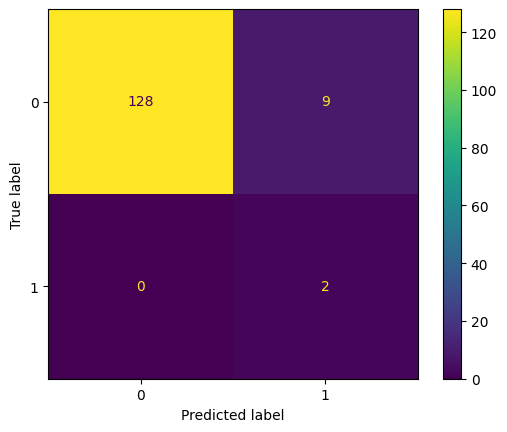

Hybrid System Evaluation Complete.


In [10]:
# Selecting the final best-performing model (likely Adaboost) based on tuning results
best_prob_model = grid.best_estimator_
print(f"Final Selected Probability Model: {best_prob_model}")

# Refitting the complementary Anomaly Model (OneClassSVM detects outliers) for a Hybrid System
anomaly_model_name = "OneClassSVM (Anomaly)"
anomaly_model = models[anomaly_model_name]
anomaly_model.fit(X_train_proc[y_train == 0])
print(f"Final Selected Anomaly Model: {anomaly_model}")


# Wrapping into a Hybrid System for Deployment
class HybridTacticalModel:
    def __init__(self, preprocessor, prob_model, anomaly_model):
        self.preprocessor = preprocessor
        self.prob_model = prob_model
        self.anomaly_model = anomaly_model

    def analyze(self, X_raw):
        X_proc = self.preprocessor.transform(X_raw)
        risk_prob = self.prob_model.predict_proba(X_proc)[0][1]
        is_anomaly = self.anomaly_model.predict(X_proc)[0] == -1
        return {"probability": float(risk_prob), "anomaly_detected": bool(is_anomaly)}


hybrid_system = HybridTacticalModel(preprocessor, best_prob_model, anomaly_model)
print("Best Models Selected and Unified into Hybrid System.")

# Visualising the Hybrid System's Predictions on Test Set
X_test_proc = preprocessor.transform(X_test)
prob_preds = best_prob_model.predict(X_test_proc)
anomaly_preds = anomaly_model.predict(X_test_proc)
hybrid_preds = np.where((prob_preds > 0.5) | (anomaly_preds == -1), 1, 0)
print(classification_report(y_test, hybrid_preds, digits=4))
ConfusionMatrixDisplay.from_predictions(y_test, hybrid_preds)
plt.show()
print("Hybrid System Evaluation Complete.")

# Task 9: Model Performance Evaluation


--- FINAL TEST SET PERFORMANCE ---
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       137
           1       1.00      0.50      0.67         2

    accuracy                           0.99       139
   macro avg       1.00      0.75      0.83       139
weighted avg       0.99      0.99      0.99       139



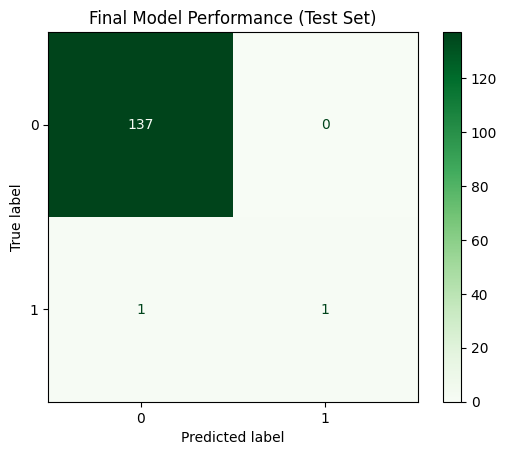

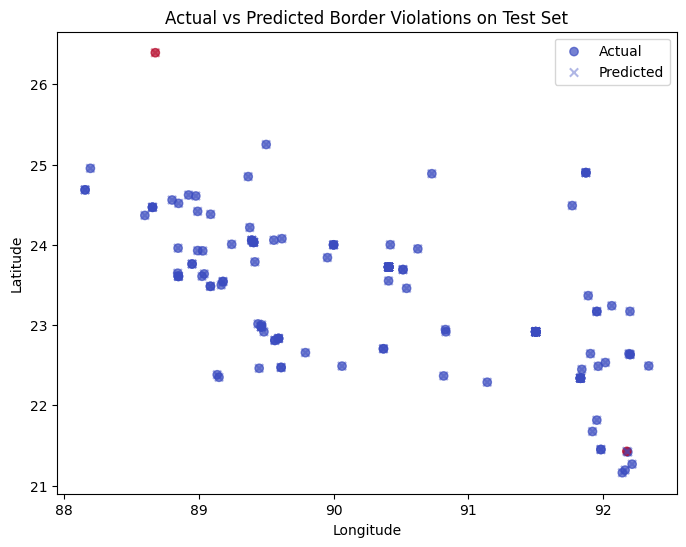

In [11]:
# Evaluating the model on the test set and printing comprehensive metrics suitable for the problem type.
print("--- FINAL TEST SET PERFORMANCE ---")

# We evaluate the probability component (Precision/Recall)
X_test_proc = preprocessor.transform(X_test)
y_pred_prob = best_prob_model.predict(X_test_proc)

# Probability Model Evaluation
print(classification_report(y_test, y_pred_prob))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_prob, cmap="Greens")
plt.title("Final Model Performance (Test Set)")
plt.show()

# Visualising prediction vs actuals
plt.figure(figsize=(8, 6))
plt.scatter(
    X_test["longitude"],
    X_test["latitude"],
    c=y_test,
    cmap="coolwarm",
    alpha=0.7,
    label="Actual",
)
plt.scatter(
    X_test["longitude"],
    X_test["latitude"],
    c=y_pred_prob,
    cmap="coolwarm",
    alpha=0.4,
    marker="x",
    label="Predicted",
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Actual vs Predicted Border Violations on Test Set")
plt.legend()
plt.show()

# Task 10: Pickling the Model to prepare for Deployment

In [12]:
with open("model.pkl", "wb") as f:
    pickle.dump(hybrid_system, f)
print("Unified Hybrid System saved to 'model.pkl'. Ready for deployment.")

Unified Hybrid System saved to 'model.pkl'. Ready for deployment.


# Gradio Interface for Model Deployment

In [13]:
# SECTORS = {
#     "Teknaf Border": (20.86, 92.30),
#     "Ukhiya Zone": (21.16, 92.14),
#     "Bandarban Hills": (22.19, 92.21),
#     "Sylhet Border": (24.89, 91.86),
#     "Dhaka Central": (23.81, 90.41),
#     "Chittagong Port": (22.34, 91.83),
#     "Cox's Bazar Coast": (21.42, 91.98),
#     "Rangamati Hills": (22.65, 92.19),
#     "Khulna Sundarbans": (22.45, 89.54),
#     "Rajshahi Border": (24.37, 88.60),
#     "Comilla Border": (23.47, 91.18),
#     "Dinajpur Border": (25.63, 88.67),
# }

# MONTHS = {
#     "Jan": 1,
#     "Feb": 2,
#     "Mar": 3,
#     "Apr": 4,
#     "May": 5,
#     "Jun": 6,
#     "Jul": 7,
#     "Aug": 8,
#     "Sep": 9,
#     "Oct": 10,
#     "Nov": 11,
#     "Dec": 12,
# }

# V_TYPES = {"State-based Action": 1, "Non-state Activity": 2, "Civilian Attacks": 3}


# # --- 4. Prediction Function ---
# def hybrid_predict(year, sector, month, violence):
#     try:
#         # A. Map Inputs
#         lat, lon = SECTORS[sector]
#         m_num = MONTHS[month]
#         vt = V_TYPES[violence]

#         # B. Create input DataFrame
#         input_data = pd.DataFrame(
#             [[float(lat), float(lon), int(year), int(m_num), int(vt)]],
#             columns=["latitude", "longitude", "year", "month", "type_of_violence"],
#         )

#         # C. Get Hybrid Intelligence
#         analysis = hybrid_system.analyze(input_data)
#         risk_prob = analysis["probability"]
#         anomaly = analysis["anomaly_detected"]

#         # D. Unified Status Logic
#         if risk_prob >= 0.20:
#             status = "🔴 RED ALERT: High Probability Border Threat"
#         elif anomaly:
#             status = "🟡 YELLOW ALERT: Unusual Activity (Anomaly Detected)"
#         else:
#             status = "🟢 GREEN: Routine Internal Patterns"

#         return {
#             "Tactical_Status": status,
#             "Intelligence_Signals": {
#                 "Historical_Pattern_Match_Prob": f"{risk_prob:.2%}",
#                 "Outlier_Detection_Warning": "ACTIVE" if anomaly else "None",
#             },
#             "Commander_Note": "Yellow alerts indicate events that don't match standard internal conflict patterns and should be verified by ground sensors/scouts.",
#             "Input_Context": {
#                 "Year": int(year),
#                 "Sector": sector,
#                 "Month": month,
#                 "Conflict_Type": violence,
#             },
#         }

#     except Exception as e:
#         return {"Error": str(e)}


# # --- 5. Interface Construction ---
# ui = gr.Interface(
#     fn=hybrid_predict,
#     inputs=[
#         gr.Number(value=2026, label="Forecast Year"),
#         gr.Dropdown(
#             choices=list(SECTORS.keys()),
#             label="Sector Selection",
#             value="Teknaf Border",
#         ),
#         gr.Dropdown(choices=list(MONTHS.keys()), label="Forecast Month", value="Jan"),
#         gr.Dropdown(
#             choices=list(V_TYPES.keys()),
#             label="Conflict Category",
#             value="State-based Action",
#         ),
#     ],
#     outputs=gr.JSON(label="Tactical Intelligence Report"),
#     title="Hybrid Early Warning System (HEWS)",
#     description="A theoretical dual-signal intelligence system combining Historical Probability (AdaBoost) and Anomaly Detection (SVM). Designed for cross-border conflict prediction. Select parameters and receive a tactical status report. Yellow alerts indicate events that don't match standard internal conflict patterns and should be verified by ground sensors/scouts. The dataset used is from UCDP Border Crossing dataset exported on 17th Januay 2026, it only includes conflict data up to year 2024.",
# )

# # --- 6. Launch ---
# if __name__ == "__main__":
#     ui.launch(
#         share=True,
#         debug=True,
#         pwa=True
#     )